# Homework 4 - Concept Drift

Load the SEA dataset ("sea.csv"). It has three features and one target column. You can learn more about this dataset with the following link (http://www.liaad.up.pt/kdus/products/datasets-for-concept-drift).

## Tasks
1. Train a SVM classifier (gamma = 0.01) with the first 10000 samples of the stream. Subsequently, evaluate it on the remaining data instances. What performance do you achieve on the train and the test set? <br /> <br />
2. Implement a Page Hinkley change detection on the datastream. Again use the first 10000 data instances for the first model training. Retrain the model when a change is detected. How many drifts do you detect in the data? Plot the score curve and also the drift detection points. Use lambda = 0.01 and batch size = 1000 for each data sample (stream.next_sample()) <br /> <br />
3. Perform a grid search on the whole dataset with the following paramters:  <br /> <br />  **Page-Hinkley:** lambda = [0.01, 0.05, 0.1, 1]  <br /> **SVM:** svm_gamma = [0.01, 0.1]  <br /> <br /> Use the first 10000 samples for the initial training and then a batch-size of 1000 samples for iterative evaluation. Print the prediction accuracy for each parameter pair. What is the best parameter pair? *Hint: You have to implement GridSearch manually.*

In [38]:
import pandas as pd
import numpy as np

In [39]:
sea = pd.read_csv('./Data/sea.csv')

In [40]:
sea.head()

feat1     feat2     feat3  label
0  6.677259  5.152133  2.982455      0
1  9.874437  8.817701  4.786266      1
2  7.118725  2.990575  1.964403      0
3  6.128244  8.449696  2.604408      1
4  7.592623  0.859845  5.763160      0

In [41]:
sea.describe()

feat1         feat2         feat3         label
count  60000.000000  60000.000000  60000.000000  60000.000000
mean       4.997519      5.007497      5.012034      0.626933
std        2.883807      2.883343      2.887424      0.483624
min        0.000029      0.000187      0.000208      0.000000
25%        2.502614      2.514903      2.515473      0.000000
50%        5.012329      5.015645      5.020778      1.000000
75%        7.500016      7.504855      7.510801      1.000000
max        9.999989      9.999788      9.999893      1.000000

In [42]:
sea.shape

(60000, 4)

In [43]:
# What about preprocessing the features??? Standardization?

## Task 1
Train a SVM classifier (gamma = 0.01) with the first 10000 samples of the stream. Subsequently, evaluate it on the remaining data instances. What performance do you achieve on the train and the test set?

In [44]:
# Code up your solution here

In [45]:
from skmultiflow.data.data_stream import DataStream

stream = DataStream(data = sea)

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [47]:
svm = SVC(gamma = 0.01)

In [48]:
stream.restart()
train = stream.next_sample(10000)

In [49]:
# Train SVM and obtain training score to answer question
svm.fit(train[0],train[1]).score(train[0], train[1])

0.8782

In [50]:
stream.n_remaining_samples()

50000

In [51]:
test = stream.next_sample(stream.n_remaining_samples())

In [52]:
test[0]

array([[1.948173, 2.128138, 6.824819],
       [4.734612, 8.425572, 8.030512],
       [5.991256, 8.355309, 8.223196],
       ...,
       [8.430418, 9.531408, 1.03455 ],
       [6.438425, 8.75962 , 6.009597],
       [0.144706, 1.157587, 0.661286]])

In [53]:
pred = svm.predict(test[0])

In [54]:
accuracy_score(test[1], pred)

0.8331

In [55]:
print(classification_report(test[1], pred))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75     18804
           1       0.82      0.93      0.87     31196

    accuracy                           0.83     50000
   macro avg       0.84      0.80      0.81     50000
weighted avg       0.84      0.83      0.83     50000



During Training wer obtain an accuracy of 0.8782 while during testing we obtain a slightly lower average accuracy of 0.8331.

## Task 2

2. Implement a Page Hinkley change detection on the datastream. Again use the first 10000 data instances for the first model training. Retrain the model when a change is detected. How many drifts do you detect in the data? Plot the score curve and also the drift detection points. Use lambda = 0.01 and batch size = 1000 for each data sample (stream.next_sample()) <br /> <br />

In [56]:
# Code up your solution here

In [57]:
# Use code from Excercise or use pre-build function?

### 1. Use function from excercise

In [58]:
 def compute_ph_statistics(score, mean_score_list, ph_sum_list):
    # Compute new mean
    sample_count = len(ph_sum_list)
    mean_new = mean_score_list[-1] + ((score - mean_score_list[-1]) / sample_count)
    mean_score_list.append(mean_new)

    # Compute new sum of deviations
    ph_sum_new = ph_sum_list[-1] + (score - mean_score_list[-1])
    ph_sum_list.append(ph_sum_new)

    # Compute change statistics s_min and s_max
    s_max = max(ph_sum_list) - ph_sum_new
    s_min = ph_sum_new - min(ph_sum_list)

    return (mean_score_list, ph_sum_list, s_max, s_min)

In [59]:
# This function resets the values of the variables in case a drift is detected
def reset_values():
    ph_mean = [0]
    ph_sum = [0]
    return(ph_mean, ph_sum) 

In [63]:
def evaluate_svm(svm_gamma=0.01, ph_lambda = 0.01):
    stream.restart()
    svm = SVC(gamma = svm_gamma)

    # Set initial values
    ph_sum = [0]
    ph_mean = [0]
    score_list = []
    drift_detected = []

    # Threshold for change detection
    #ph_lambda = 0.01

    X_train, y_train = stream.next_sample(10000)
    svm.fit(X_train, y_train)

    for i in range(int(stream.n_remaining_samples()/1000)):

        X_test, _ = stream.next_sample(1000)
        y_predict = svm.predict(X_test)

        #Receive true labels after a while
        y_test = stream.current_sample_y
        score = accuracy_score(y_test, y_predict)
        score_list.append(score)

        # Compute statistics and then compare lambda
        ph_mean, ph_sum, s_max, s_min = compute_ph_statistics(score, ph_mean, ph_sum)

        if ((s_max > ph_lambda) or (s_min > ph_lambda)):
            ph_mean, ph_sum = reset_values()
            print('Drift detected at: '+str(60000-stream.n_remaining_samples())+ ' samples')

            # Save drift point for later plotting
            drift_detected.append(i)
            #fit svm new if drift is detected
            svm.fit(X_test, y_test)
        
    return score_list, drift_detected

In [64]:
score_list, drift_detected = evaluate_svm()

Drift detected at: 15000 samples
Drift detected at: 18000 samples
Drift detected at: 22000 samples
Drift detected at: 27000 samples
Drift detected at: 31000 samples
Drift detected at: 33000 samples
Drift detected at: 38000 samples
Drift detected at: 42000 samples
Drift detected at: 46000 samples
Drift detected at: 52000 samples
Drift detected at: 54000 samples
Drift detected at: 56000 samples
Drift detected at: 60000 samples


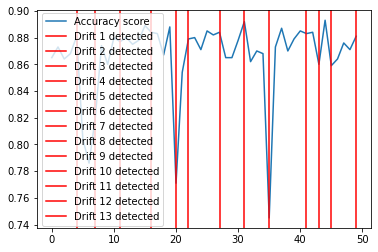

Accuracy: 0.8662400000000001


In [65]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(score_list, label = 'Accuracy score')

j = 1
for i in drift_detected:
    plt.axvline(i, color = 'red', label = 'Drift {} detected'.format(j))
    j += 1
    
plt.legend()
plt.show()
print('Accuracy:', np.mean(score_list))


13 drifts can be detected within the data. [In this case I assumed to train the model on the first 10000 data points and then re-evaluate for drifts every 1000 incominh data points - since excercise was not specific]


### 2. Use function from skmultiflow

In [66]:
import numpy as np
from skmultiflow.drift_detection import PageHinkley
stream.restart()
ph = PageHinkley(threshold=0.01)

In [67]:
stream.restart()
svm = SVC()

# Set initial values
ph_sum = [0]
ph_mean = [0]
score_list = []
drift_detected = []

# Threshold for change detection
#ph_lambda = 0.01

X_train, y_train = stream.next_sample(10000)
svm.fit(X_train, y_train)

for i in range(int(stream.n_remaining_samples()/1000)):
    
    X_test, _ = stream.next_sample(1000)
    y_predict = svm.predict(X_test)
    
    #Receive true labels after a while
    y_test = stream.current_sample_y
    score = accuracy_score(y_test, y_predict)
    score_list.append(score)
    
    # Use Ph function    
    for el in X_test:
        print(el)
        ph.add_element(el)

    if ph.detected_change():

        print('Drift detected at: '+str(60000-stream.n_remaining_samples())+ ' samples')
        ph.reset()
        # Save drift point for later plotting
        drift_detected.append(i)
        #fit svm new if drift is detected
        svm.fit(X_test, y_test)

[1.948173 2.128138 6.824819]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(score_list, label = 'Accuracy score')

j = 1
for i in drift_detected:
    plt.axvline(i, color = 'red', label = 'Drift {} detected'.format(j))
    j += 1
    
plt.legend()
plt.show()
print('Accuracy:', np.mean(score_list))

## Task 3

3. Perform a grid search on the whole dataset with the following paramters:  <br /> <br />  **Page-Hinkley:** lambda = [0.01, 0.05, 0.1, 1]  <br /> **SVM:** svm_gamma = [0.01, 0.1]  <br /> <br /> Use the first 10000 samples for the initial training and then a batch-size of 1000 samples for iterative evaluation. Print the prediction accuracy for each parameter pair. What is the best parameter pair? *Hint: You have to implement GridSearch manually.*

In [1]:
# Code up your solution here

In [71]:
ph_params = [0.01, 0.05, 0.1, 1]
svm_params = [0.01, 0.1]
scores = dict()
i = 0
for ph_lambda in ph_params:
    for gamma in svm_params:
        score_list, drift_detected = evaluate_svm(gamma, ph_lambda)
        key = 'lambda: ' +str(ph_lambda)+' , gamma:'+str(gamma)
        scores[key] = np.mean(score_list) 
        i = i+1

Drift detected at: 15000 samples
Drift detected at: 18000 samples
Drift detected at: 22000 samples
Drift detected at: 27000 samples
Drift detected at: 31000 samples
Drift detected at: 33000 samples
Drift detected at: 38000 samples
Drift detected at: 42000 samples
Drift detected at: 46000 samples
Drift detected at: 52000 samples
Drift detected at: 54000 samples
Drift detected at: 56000 samples
Drift detected at: 60000 samples
Drift detected at: 15000 samples
Drift detected at: 18000 samples
Drift detected at: 22000 samples
Drift detected at: 29000 samples
Drift detected at: 31000 samples
Drift detected at: 34000 samples
Drift detected at: 36000 samples
Drift detected at: 40000 samples
Drift detected at: 42000 samples
Drift detected at: 46000 samples
Drift detected at: 49000 samples
Drift detected at: 52000 samples
Drift detected at: 54000 samples
Drift detected at: 57000 samples
Drift detected at: 17000 samples
Drift detected at: 31000 samples
Drift detected at: 46000 samples
Drift dete

In [73]:
scores

{'lambda: 0.01 , gamma:0.01': 0.8662400000000001,
 'lambda: 0.01 , gamma:0.1': 0.8713200000000001,
 'lambda: 0.05 , gamma:0.01': 0.8660399999999998,
 'lambda: 0.05 , gamma:0.1': 0.8737600000000001,
 'lambda: 0.1 , gamma:0.01': 0.86854,
 'lambda: 0.1 , gamma:0.1': 0.8714000000000002,
 'lambda: 1 , gamma:0.01': 0.8331000000000001,
 'lambda: 1 , gamma:0.1': 0.8392999999999999}

The best accuracy was achieved with the parameters: 'lambda: 0.05 , gamma:0.1': 0.8737600000000001'

[This statement is based on the mean accuracy - since no exact specification was given in the excercise ]